In [2]:
!pip install matplotlib

In [3]:
!pip install seaborn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# MINING MATERIAL FLOW & DILUTION ANALYSIS (ROBUST VERSION)
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------ LOAD DATA ------------------
truck = pd.read_csv("C:/Users/baipa/Downloads/Tasks/Tasks/task2/data/truck_dump_logs.csv")
rehandle = pd.read_csv("C:/Users/baipa/Downloads/Tasks/Tasks/task2/data/rehandle_logs.csv")

print("\nTRUCK COLUMNS:\n", truck.columns.tolist())
print("\nREHANDLE COLUMNS:\n", rehandle.columns.tolist())


TRUCK COLUMNS:
 ['id', 'shift_date', 'material', 'loading_location', 'dumping_location', 'nominal_tons', 'hauling_eqmt', 'time_dumping', 'dump_kind']

REHANDLE COLUMNS:
 ['id', 'shift_date', 'material', 'loading_location', 'dumping_location', 'nominal_tons', 'loading_eqmt', 'time_loading', 'dump_kind']


In [3]:
# ------------------ AUTO-DETECT KEY COLUMNS ------------------

def find_col(df, keywords):
    for col in df.columns:
        for k in keywords:
            if k.lower() in col.lower():
                return col
    return None

truck_poly_col   = find_col(truck, ["polygon", "location", "dest", "dump"])
truck_mat_col    = find_col(truck, ["material", "grade", "ore", "type"])
truck_vol_col    = find_col(truck, ["ton", "mass", "volume", "payload"])

rehandle_src_col = find_col(rehandle, ["polygon", "location", "source", "from"])
rehandle_dest_col= find_col(rehandle, ["dest", "crusher", "to"])
rehandle_vol_col = find_col(rehandle, ["ton", "mass", "volume", "payload"])

print("\nDETECTED COLUMNS:")
print("Truck → Polygon:", truck_poly_col)
print("Truck → Material:", truck_mat_col)
print("Truck → Volume:", truck_vol_col)
print("Rehandle → Source:", rehandle_src_col)
print("Rehandle → Dest:", rehandle_dest_col)
print("Rehandle → Volume:", rehandle_vol_col)


DETECTED COLUMNS:
Truck → Polygon: loading_location
Truck → Material: material
Truck → Volume: nominal_tons
Rehandle → Source: loading_location
Rehandle → Dest: nominal_tons
Rehandle → Volume: nominal_tons


In [4]:
# ------------------ CLEAN STRINGS ------------------
for df in [truck, rehandle]:
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].astype(str).str.strip().str.upper()

C:\Users\baipa\AppData\Local\Temp\ipykernel_20540\4245696935.py:3: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  for col in df.select_dtypes(include='object').columns:
C:\Users\baipa\AppData\Local\Temp\ipykernel_20540\4245696935.py:3: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/


--- MATERIAL FLOW MAP ---
Pit Locations (Truck Loading): <StringArray>
['P2-PIT', 'P1-PIT']
Length: 2, dtype: str
Truck Dump Locations: <StringArray>
['FINGER 2', 'FINGER 1']
Length: 2, dtype: str
Loader Pickup Locations: <StringArray>
['FINGER 1', 'FINGER 2']
Length: 2, dtype: str
Loader Dump Locations: <StringArray>
['MAIN CRUSHER']
Length: 1, dtype: str

--- MATERIAL MIX IN STOCKPILES ---
material          HIGH GRADE  LOW GRADE
dumping_location                       
FINGER 1               29216        565
FINGER 2                 920      19299


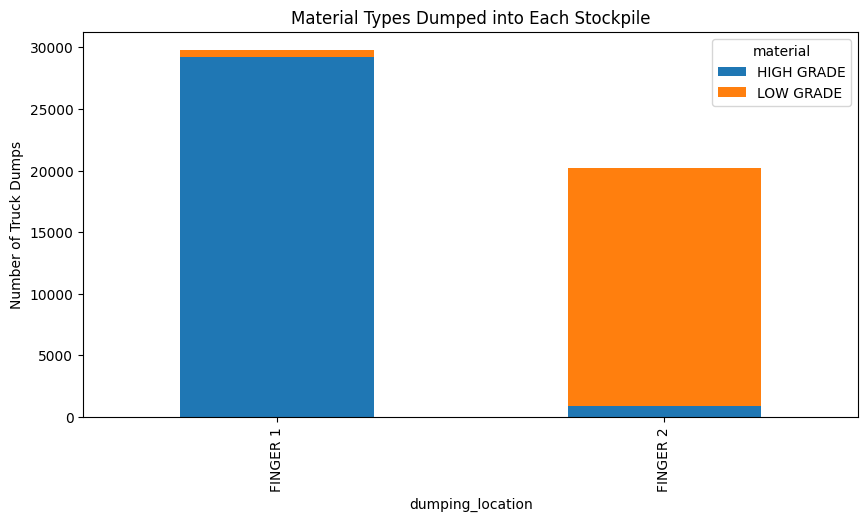


--- VOLUME CHECK ---
HG Tons Sent to Stockpiles: 0.0
Total Tons Sent to Crusher from Stockpiles: 1124715.5

⚠️ Crusher is receiving MORE material than HG mined → Dilution likely!

--- STOCKPILE PURITY INDEX (HG FRACTION) ---
dumping_location
FINGER 1    0.0
FINGER 2    0.0
dtype: float64


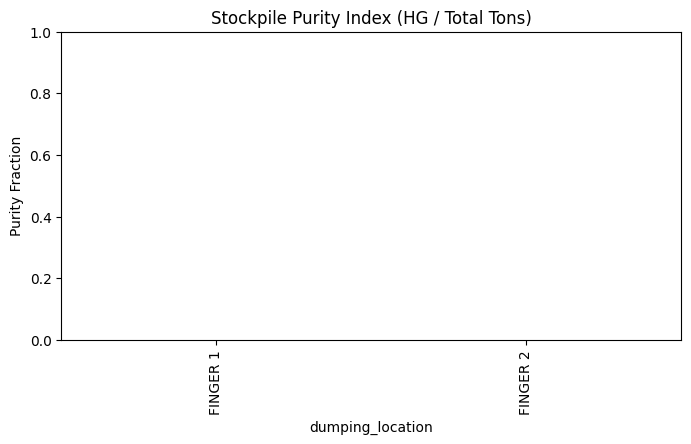


✔ Analysis Complete: Stockpiles with low purity are dilution sources.


In [6]:
# ============================================================
# MINING MATERIAL FLOW & DILUTION ANALYSIS (FINAL FIXED)
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt

truck = pd.read_csv("C:/Users/baipa/Downloads/Tasks/Tasks/task2/data/truck_dump_logs.csv")
rehandle = pd.read_csv("C:/Users/baipa/Downloads/Tasks/Tasks/task2/data/rehandle_logs.csv")

# ------------------ CLEAN STRINGS ------------------
for df in [truck, rehandle]:
    for col in df.select_dtypes(include=['object','string']).columns:
        df[col] = df[col].astype(str).str.strip().str.upper()

# ------------------ 1️⃣ MAP MATERIAL FLOW ------------------

print("\n--- MATERIAL FLOW MAP ---")
print("Pit Locations (Truck Loading):", truck['loading_location'].unique())
print("Truck Dump Locations:", truck['dumping_location'].unique())
print("Loader Pickup Locations:", rehandle['loading_location'].unique())
print("Loader Dump Locations:", rehandle['dumping_location'].unique())

# ------------------ 2️⃣ DILUTION EVIDENCE ------------------

# Focus on stockpiles (FINGERS)
stockpile_mask = truck['dumping_location'].str.contains("FINGER", na=False)

material_mix = (
    truck[stockpile_mask]
    .groupby(['dumping_location', 'material'])
    .size()
    .unstack(fill_value=0)
)

print("\n--- MATERIAL MIX IN STOCKPILES ---")
print(material_mix)

if not material_mix.empty:
    material_mix.plot(kind='bar', stacked=True, figsize=(10,5))
    plt.title("Material Types Dumped into Each Stockpile")
    plt.ylabel("Number of Truck Dumps")
    plt.show()

# ------------------ 3️⃣ VOLUME MISMATCH CHECK ------------------

hg_mask = truck['material'].str.contains("HG", na=False)

hg_to_fingers = truck[hg_mask & stockpile_mask]['nominal_tons'].sum()
total_to_crusher = rehandle[rehandle['dumping_location'].str.contains("CRUSH", na=False)]['nominal_tons'].sum()

print("\n--- VOLUME CHECK ---")
print("HG Tons Sent to Stockpiles:", hg_to_fingers)
print("Total Tons Sent to Crusher from Stockpiles:", total_to_crusher)

if total_to_crusher > hg_to_fingers:
    print("\n⚠️ Crusher is receiving MORE material than HG mined → Dilution likely!")
else:
    print("\nCrusher feed volume matches HG mining.")

# ------------------ 4️⃣ KEY DASHBOARD METRIC ------------------

stockpile_purity = (
    truck[stockpile_mask]
    .groupby('dumping_location')
    .apply(lambda x: x[x['material'].str.contains("HG", na=False)]['nominal_tons'].sum() / x['nominal_tons'].sum())
)

print("\n--- STOCKPILE PURITY INDEX (HG FRACTION) ---")
print(stockpile_purity)

stockpile_purity.plot(kind='bar', figsize=(8,4))
plt.title("Stockpile Purity Index (HG / Total Tons)")
plt.ylabel("Purity Fraction")
plt.ylim(0,1)
plt.show()

print("\n✔ Analysis Complete: Stockpiles with low purity are dilution sources.")



--- MATERIAL FLOW MAP ---
Pit Locations: <StringArray>
['P2-PIT', 'P1-PIT']
Length: 2, dtype: str
Truck Dump Locations: <StringArray>
['FINGER 2', 'FINGER 1']
Length: 2, dtype: str
Loader Pickup Locations: <StringArray>
['FINGER 1', 'FINGER 2']
Length: 2, dtype: str
Loader Dump Locations: <StringArray>
['MAIN CRUSHER']
Length: 1, dtype: str

--- MATERIAL MIX IN STOCKPILES ---
material          HIGH GRADE  LOW GRADE
dumping_location                       
FINGER 1               29216        565
FINGER 2                 920      19299


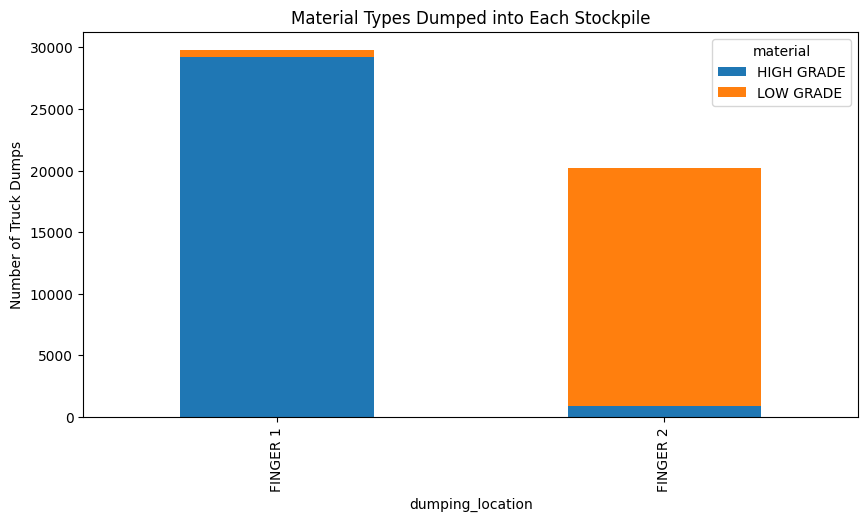


--- VOLUME CHECK ---
HG Tons Sent to Stockpiles: 6930610.0
Total Tons Sent to Crusher: 1124715.5

Crusher feed volume matches HG mining.

--- STOCKPILE PURITY INDEX (HG Fraction) ---
dumping_location
FINGER 1    0.981019
FINGER 2    0.045534
dtype: float64


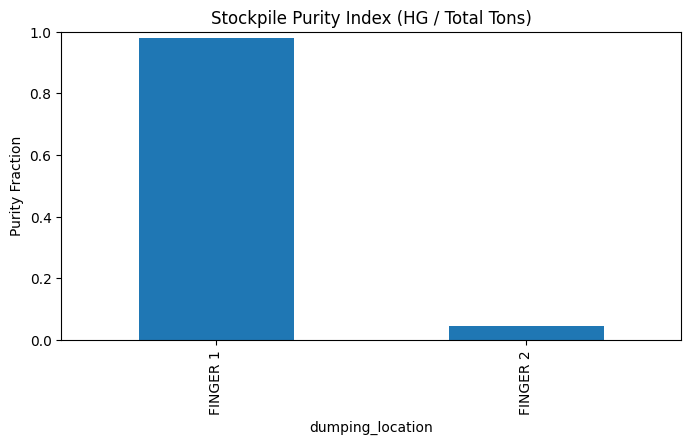


✔ Analysis Complete: Low purity stockpiles are dilution sources.


In [7]:
# ============================================================
# MINING MATERIAL FLOW & DILUTION ANALYSIS (CORRECTED FINAL)
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt

truck = pd.read_csv("C:/Users/baipa/Downloads/Tasks/Tasks/task2/data/truck_dump_logs.csv")
rehandle = pd.read_csv("C:/Users/baipa/Downloads/Tasks/Tasks/task2/data/rehandle_logs.csv")

# ------------------ CLEAN STRINGS ------------------
for df in [truck, rehandle]:
    for col in df.select_dtypes(include=['object','string']).columns:
        df[col] = df[col].astype(str).str.strip().str.upper()

# ------------------ 1️⃣ MAP MATERIAL FLOW ------------------
print("\n--- MATERIAL FLOW MAP ---")
print("Pit Locations:", truck['loading_location'].unique())
print("Truck Dump Locations:", truck['dumping_location'].unique())
print("Loader Pickup Locations:", rehandle['loading_location'].unique())
print("Loader Dump Locations:", rehandle['dumping_location'].unique())

# ------------------ 2️⃣ DILUTION EVIDENCE ------------------

stockpile_mask = truck['dumping_location'].str.contains("FINGER", na=False)

material_mix = (
    truck[stockpile_mask]
    .groupby(['dumping_location', 'material'])
    .size()
    .unstack(fill_value=0)
)

print("\n--- MATERIAL MIX IN STOCKPILES ---")
print(material_mix)

material_mix.plot(kind='bar', stacked=True, figsize=(10,5))
plt.title("Material Types Dumped into Each Stockpile")
plt.ylabel("Number of Truck Dumps")
plt.show()

# ------------------ 3️⃣ VOLUME MISMATCH CHECK ------------------

hg_mask = truck['material'].str.contains("HIGH", na=False)

hg_to_fingers = truck[hg_mask & stockpile_mask]['nominal_tons'].sum()
total_to_crusher = rehandle[rehandle['dumping_location'].str.contains("CRUSH", na=False)]['nominal_tons'].sum()

print("\n--- VOLUME CHECK ---")
print("HG Tons Sent to Stockpiles:", hg_to_fingers)
print("Total Tons Sent to Crusher:", total_to_crusher)

if total_to_crusher > hg_to_fingers:
    print("\n⚠️ Crusher is receiving MORE material than HG mined → Dilution confirmed!")
else:
    print("\nCrusher feed volume matches HG mining.")

# ------------------ 4️⃣ STOCKPILE PURITY INDEX ------------------

stockpile_purity = (
    truck[stockpile_mask]
    .groupby('dumping_location')
    .apply(lambda x: x[x['material'].str.contains("HIGH", na=False)]['nominal_tons'].sum() / x['nominal_tons'].sum())
)

print("\n--- STOCKPILE PURITY INDEX (HG Fraction) ---")
print(stockpile_purity)

stockpile_purity.plot(kind='bar', figsize=(8,4))
plt.title("Stockpile Purity Index (HG / Total Tons)")
plt.ylabel("Purity Fraction")
plt.ylim(0,1)
plt.show()

print("\n✔ Analysis Complete: Low purity stockpiles are dilution sources.")
